# Statistical analysis of each model

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

# add regular stat for skeptics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

# import bambi
import bambi as bm

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# grab data
df = pd.read_csv('../scr_amg_hipp_all.csv')

In [3]:
df.head(10)

sub  Condition  Event.Nr  CDA.AmpSum  expected_value        pe     scr  \
0  sub-189  CSplusUS1         1      0.2852        0.775073  0.500000  0.2852   
1  sub-189   CSminus1         2      0.1033        0.772940 -0.500000  0.1033   
2  sub-189    CSplus1         3      0.0783        0.774003 -0.500680  0.0783   
3  sub-189  CSplusUS1         4      0.1772        0.775070  0.500002  0.1772   
4  sub-189   CSminus1         5      0.0000        0.771878 -0.499320  0.0000   
5  sub-189    CSplus1         6      0.0000        0.774000 -0.500678  0.0000   
6  sub-189    CSplus1         7      0.0000        0.772933 -0.499995  0.0000   
7  sub-189   CSminus1         8      0.0000        0.770818 -0.498642  0.0000   
8  sub-189  CSplusUS1         9      0.2063        0.774003  0.500684  0.2063   
9  sub-189   CSminus1        10      0.0000        0.769763 -0.497967  0.0000   

   index  subject  trialNo  condition  coupling       amg      Sub group  \
0   1794  sub-189        1  CSplusUS1  0.309524  0.981121  sub-189    HC   
1   1795  sub-189        2   CSminus1 -0.571429 -0.027048  sub-189    HC   
2   1796  sub-189        3    CSplus1 -0.476190 -0.045910  sub-189    HC   
3   1797  sub-189        4  CSplusUS1  0.166667 -0.674150  sub-189    HC   
4   1798  sub-189        5   CSminus1  0.214286 -0.065602  sub-189    HC   
5   1799  sub-189        6    CSplus1 -0.690476 -0.398827  sub-189    HC   
6   1800  sub-189        7    CSplus1  0.285714 -0.104992  sub-189    HC   
7   1801  sub-189        8   CSminus1 -0.404762 -0.423804  sub-189    HC   
8   1802  sub-189        9  CSplusUS1  0.071429  0.154643  sub-189    HC   
9   1803  sub-189       10   CSminus1 -0.571429 -0.164440  sub-189    HC   

  Eprime  amg_vmpfc  amg_HippAnt  
0      A   0.904762     0.571429  
1      A   0.404762    -0.119048  
2      A   0.333333    -0.642857  
3      A   0.690476     0.357143  
4      A   0.595238     0.309524  
5      A   0.428571    -0.238095  
6      A  -0.023810    -0.071429  
7      A  -0.047619    -0.190476  
8      A   0.571429     0.047619  
9      A   0.119048    -0.238095

In [4]:
df.coupling.std()

0.43208726413391557

<AxesSubplot:xlabel='scr', ylabel='Count'>

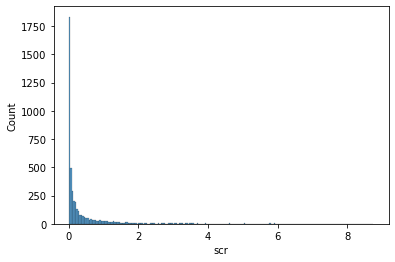

In [5]:
sns.histplot(df.scr)

<AxesSubplot:xlabel='coupling', ylabel='Count'>

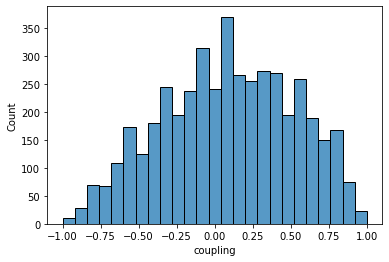

In [6]:
sns.histplot(df.coupling)

## Coupling predicted by condition 
- Hypothesis: CS+US will have higher coupling compared to CS+ and CS-

In [10]:
glm = smf.mixedlm('coupling ~ C(condition) + trialNo+ amg', data=df, 
    groups = 'subject', 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     coupling  
No. Observations:      4485        Method:                 REML      
No. Groups:            65          Scale:                  0.1498    
Min. group size:       69          Log-Likelihood:         -2223.1579
Max. group size:       69          Converged:              Yes       
Mean group size:       69.0                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.014    0.029  0.495 0.620 -0.042  0.070
C(condition)[T.CSminus2]   -0.045    0.027 -1.632 0.103 -0.099  0.009
C(condition)[T.CSminusUS2]  0.038    0.029  1.339 0.181 -0.018  0.094
C(condition)[T.CSplus1]    -0.022    0.020 -1.114 0.265 -0.060  0.017
C(condition)[T.CSplus2]    -0.050   

In [7]:
# Bayes model
# organize data
df['sub'] = df['sub'].astype('category')
#df['condition'] = df['condition'].astype('category')

n_sub = len(df['sub'].unique())
subIDX = df['sub'].cat.codes.values
# condition
n_cond = len(df['condition'].unique())
#condIDX = df['condition'].cat.codes.values
trials = df.trialNo.values - 1
amygdala = df.amg.values
# trialNo
y = df.coupling.values - df.coupling.mean()

In [8]:
df['condition'].unique()

array(['CSplusUS1', 'CSminus1', 'CSplus1', 'CSminusUS2', 'CSplus2',
       'CSminus2'], dtype=object)

In [9]:
# generating condition index
df['cond'] = df['condition']#
df = df.replace(to_replace={'cond': {'CSminus1':0, 'CSplus1':1, 'CSplusUS1':2, 'CSplus2':3, 'CSminus2':4, 'CSminusUS2':5}})

In [10]:
condIDX = df.cond.values

In [12]:
# start simple
with pm.Model() as model1:
    a = pm.Normal('a', mu=0, sigma=2)
    b = pm.Normal('b', mu=0, sigma=2, shape=1)
    
    eps = pm.HalfCauchy('eps', 5)
    mu = a + b*condIDX
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=y)
    
    trace1 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 10 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

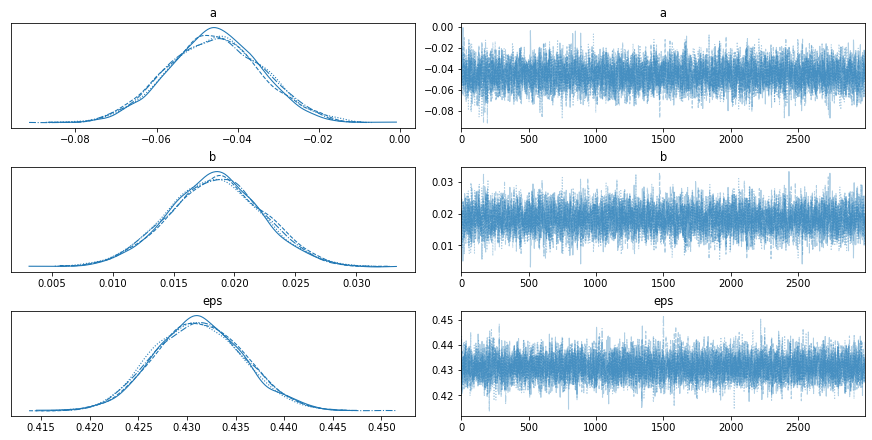

In [17]:
az.plot_trace(trace1)

In [13]:
az.summary(trace1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a    -0.045  0.012  -0.068   -0.024        0.0      0.0    4552.0    5663.0   
b[0]  0.018  0.004   0.011    0.026        0.0      0.0    4799.0    5644.0   
eps   0.431  0.005   0.423    0.440        0.0      0.0    6200.0    5891.0   

      r_hat  
a       1.0  
b[0]    1.0  
eps     1.0

In [15]:
# estimating standard coefficients
0.431/ 0.005

86.2

In [14]:
# give random intercept
with pm.Model() as model2:
    a = pm.Normal('a', mu=0, sigma=2, shape=n_sub)
    b = pm.Normal('b', mu=0, sigma=2, shape=1)
    
    eps = pm.HalfCauchy('eps', 5)
    mu = a[subIDX] + b*condIDX
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    
    trace2 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

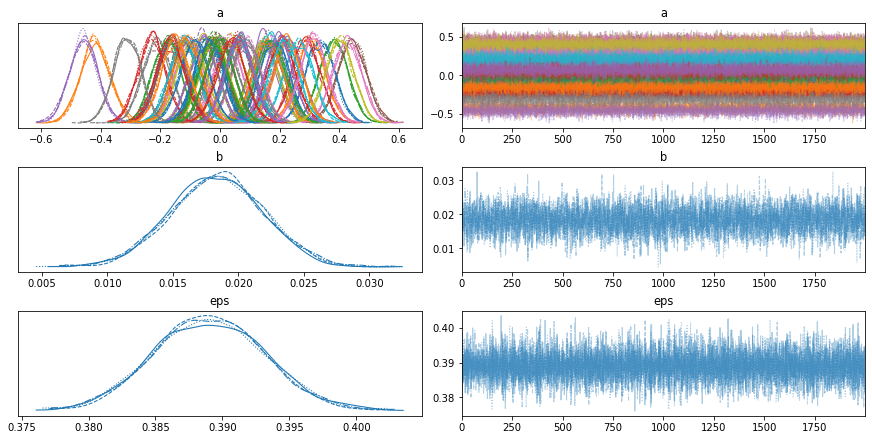

In [15]:
az.plot_trace(trace2)

In [16]:
az.summary(trace2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0]   0.062  0.048  -0.031    0.151        0.0    0.000   17449.0    5477.0   
a[1]  -0.419  0.049  -0.511   -0.327        0.0    0.000   16661.0    5251.0   
a[2]   0.382  0.047   0.294    0.470        0.0    0.000   18243.0    6020.0   
a[3]   0.068  0.048  -0.022    0.157        0.0    0.000   15188.0    4969.0   
a[4]   0.145  0.048   0.057    0.237        0.0    0.000   17471.0    5602.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
a[62] -0.001  0.048  -0.089    0.090        0.0    0.001   16790.0    5755.0   
a[63]  0.037  0.048  -0.049    0.131        0.0    0.000   16174.0    5474.0   
a[64]  0.065  0.046  -0.023    0.149        0.0    0.000   16702.0    6258.0   
b[0]   0.018  0.004   0.012    0.025        0.0    0.000    4602.0    6056.0   
eps    0.389  0.004   0.381    0.396        0.0    0.000   16216.0    5315.0   

       r_hat  
a[0]     1.0  
a[1]     1.0  
a[2]     1.0  
a[3]     1.0  
a[4]     1.0  
...      ...  
a[62]    1.0  
a[63]    1.0  
a[64]    1.0  
b[0]     1.0  
eps      1.0  

[67 rows x 9 columns]

In [18]:
# adding trials
# give random intercept
with pm.Model() as model3:
    a = pm.Normal('a', mu=0, sigma=2, shape=n_sub)
    b = pm.Normal('b', mu=0, sigma=2, shape=n_sub)
    #b2 = pm.Normal('b2', mu=0, sigma=2)#, shape=nTrials)
    eps = pm.HalfCauchy('eps', 5)
    mu = a[subIDX] + b[subIDX]*condIDX 
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace3 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=3000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 79 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

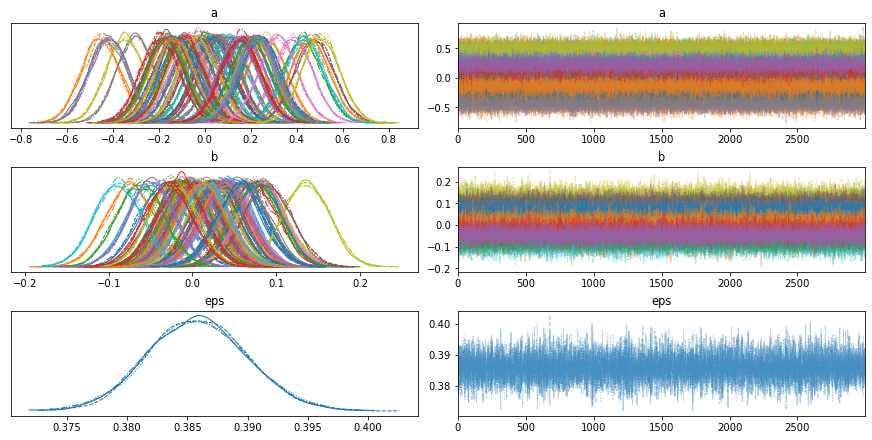

In [19]:
az.plot_trace(trace3)

In [20]:
az.compare({'model1': trace1, 'model2': trace2, 'model3': trace3})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank          loo       p_loo       d_loo    weight         se  \
model3     0 -2158.680307  128.457577    0.000000  0.541239  42.662611   
model2     1 -2162.813818   66.166858    4.133511  0.412477  41.861133   
model1     2 -2591.750047    2.644520  433.069740  0.046285  37.387080   

              dse  warning loo_scale  
model3   0.000000    False       log  
model2  12.000974    False       log  
model1  32.177007    False       log

In [50]:
with pm.Model() as model4:
    # hyper for condition
    b_cond = pm.Normal('b_cond', mu=0, sigma=.5, shape=n_cond)
   
    a = pm.Normal('a', mu=0, sigma=.5, shape=n_sub)
  
    eps = pm.HalfCauchy('eps', .5)
  
    mu = a[subIDX] + b_cond[condIDX]
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace4 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, a, b_cond]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

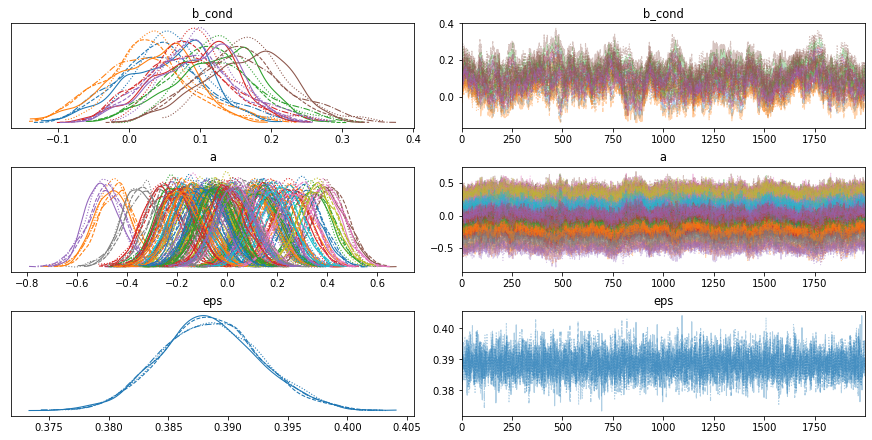

In [51]:
az.plot_trace(trace4)

In [52]:
az.summary(trace4, var_names='b_cond')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_cond[0]  0.052  0.060  -0.059    0.170      0.007    0.005      65.0   
b_cond[1]  0.029  0.060  -0.091    0.140      0.007    0.005      69.0   
b_cond[2]  0.120  0.062   0.006    0.242      0.007    0.006      71.0   
b_cond[3]  0.087  0.060  -0.030    0.195      0.008    0.005      64.0   
b_cond[4]  0.093  0.059  -0.023    0.204      0.007    0.005      67.0   
b_cond[5]  0.161  0.061   0.050    0.283      0.008    0.006      66.0   

           ess_tail  r_hat  
b_cond[0]     179.0   1.06  
b_cond[1]     184.0   1.06  
b_cond[2]     177.0   1.06  
b_cond[3]     191.0   1.06  
b_cond[4]     179.0   1.06  
b_cond[5]     175.0   1.06

In [41]:
az.compare({'model1': trace1, 'model2': trace2, 'model3': trace3, 'model4': trace4})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


rank          loo       p_loo       d_loo    weight         se  \
model4     0 -2158.470529   69.684394    0.000000  0.453698  41.736732   
model3     1 -2158.680307  128.457577    0.209778  0.507026  42.662611   
model2     2 -2162.813818   66.166858    4.343289  0.000000  41.861133   
model1     3 -2591.750047    2.644520  433.279518  0.039277  37.387080   

              dse  warning loo_scale  
model4   0.000000    False       log  
model3  12.679755    False       log  
model2   4.109188    False       log  
model1  29.954062    False       log

<AxesSubplot:>

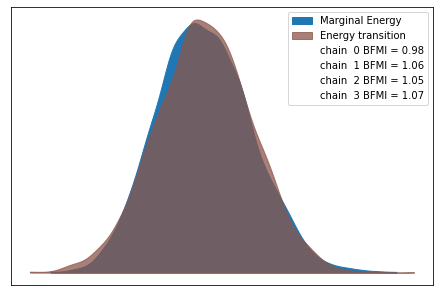

In [43]:
az.plot_energy(trace4)

In [59]:
# add hyperpriors
with pm.Model() as model5:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    
    b_cond = pm.Normal('b_cond', mu=mu_b, sigma=sigma_b, shape=n_cond)
   
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_sub)
  
    eps = pm.HalfCauchy('eps', .5)
  
    mu = a[subIDX] + b_cond[condIDX]
    
    y_hat = pm.Normal('y', mu=mu, sigma=eps, observed=df.coupling)
    
    trace5 = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, a, b_cond, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

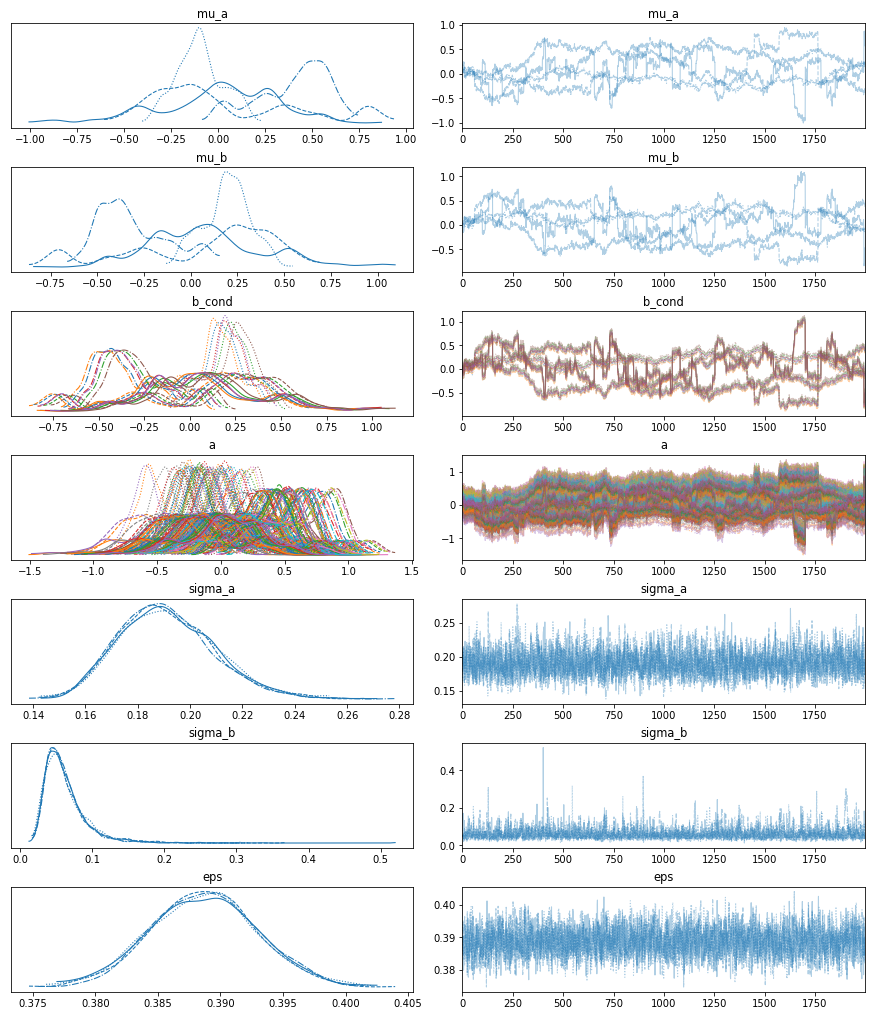

In [60]:
az.plot_trace(trace5)

In [62]:
az.compare({'model3': trace3, 'model4': trace4, 'model5':trace5})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/n

rank          loo       p_loo     d_loo    weight         se  \
model5     0 -2157.228343   66.436289  0.000000  0.503721  41.307746   
model4     1 -2158.524260   69.731959  1.295917  0.000000  41.728321   
model3     2 -2158.680307  128.457577  1.451964  0.496279  42.662611   

              dse  warning loo_scale  
model5   0.000000    False       log  
model4   1.651153    False       log  
model3  12.706554    False       log

## Chosen model

In [47]:
# use reparametarization of the same model
# add hyperpriors
with pm.Model() as model6:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
   
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.coupling)
    
    trace6 = pm.sample(target_accept=.95, chains=4, cores=4, return_inferencedata=True, draws=2000, tune=2000, random_seed=123)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 493 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b_matt'}>,
        <AxesSubplot:title={'center':'b_matt'}>],
       [<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>]], dtype=object)

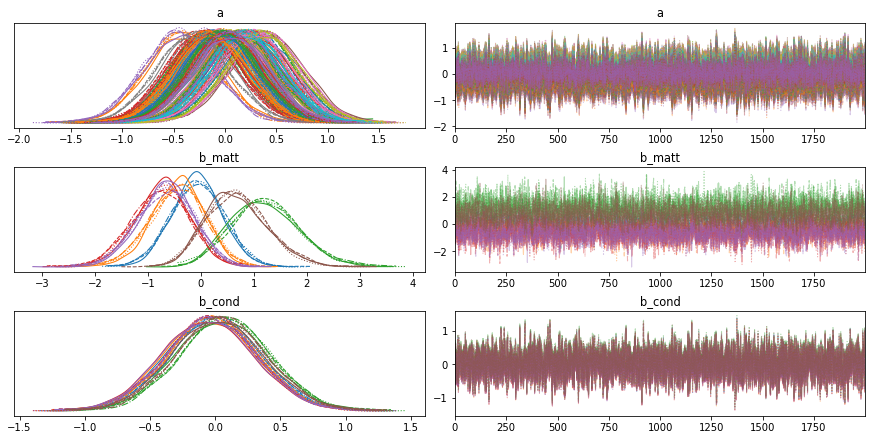

In [16]:
az.plot_trace(trace6, var_names=['a','b_matt','b_cond'])

In [17]:
az.summary(trace6, var_names=['b_cond','b_matt'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_cond[0] -0.001  0.352  -0.640    0.672      0.006    0.004    3321.0   
b_cond[1] -0.022  0.352  -0.656    0.652      0.006    0.004    3313.0   
b_cond[2]  0.071  0.352  -0.589    0.723      0.006    0.004    3337.0   
b_cond[3] -0.040  0.353  -0.675    0.647      0.006    0.004    3289.0   
b_cond[4] -0.036  0.353  -0.670    0.644      0.006    0.004    3273.0   
b_cond[5]  0.039  0.353  -0.603    0.713      0.006    0.004    3302.0   
b_matt[0] -0.066  0.500  -1.027    0.853      0.010    0.007    2423.0   
b_matt[1] -0.435  0.529  -1.463    0.532      0.011    0.008    2289.0   
b_matt[2]  1.221  0.647  -0.037    2.367      0.012    0.009    2669.0   
b_matt[3] -0.749  0.545  -1.832    0.209      0.011    0.008    2314.0   
b_matt[4] -0.658  0.539  -1.678    0.334      0.011    0.008    2467.0   
b_matt[5]  0.684  0.584  -0.389    1.778      0.011    0.008    2709.0   

           ess_tail  r_hat  
b_cond[0]    4837.0    1.0  
b_cond[1]    4747.0    1.0  
b_cond[2]    4733.0    1.0  
b_cond[3]    4837.0    1.0  
b_cond[4]    4880.0    1.0  
b_cond[5]    4868.0    1.0  
b_matt[0]    4059.0    1.0  
b_matt[1]    3437.0    1.0  
b_matt[2]    4571.0    1.0  
b_matt[3]    3763.0    1.0  
b_matt[4]    3905.0    1.0  
b_matt[5]    4506.0    1.0

In [46]:
trace6.posterior.b_cond.values.shape

(4, 2000, 6)

# calculate R_2

In [84]:
with model6:
    trace6.extend(az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace6)))

In [87]:
trace6#.posterior_predictive

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

In [100]:
y_true = trace6.observed_data["y_hat"].values
y_pred = trace6.posterior_predictive.stack(sample=("chain", "draw"))["y_hat"].values.T
az.r2_score(y_true, y_pred)

r2        0.186722
r2_std    0.002425
dtype: float64

In [74]:
az.compare({'model3': trace3, 'model4': trace4, 'model5':trace5, 'model6':trace6})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/n

rank          loo       p_loo     d_loo        weight         se  \
model5     0 -2157.228343   66.436289  0.000000  5.037195e-01  41.307746   
model6     1 -2157.235262   66.535220  0.006919  0.000000e+00  41.347988   
model4     2 -2158.524260   69.731959  1.295917  1.110223e-16  41.728321   
model3     3 -2158.680307  128.457577  1.451964  4.962805e-01  42.662611   

              dse  warning loo_scale  
model5   0.000000    False       log  
model6   0.117187    False       log  
model4   1.651153    False       log  
model3  12.706554    False       log

array([<AxesSubplot:>], dtype=object)

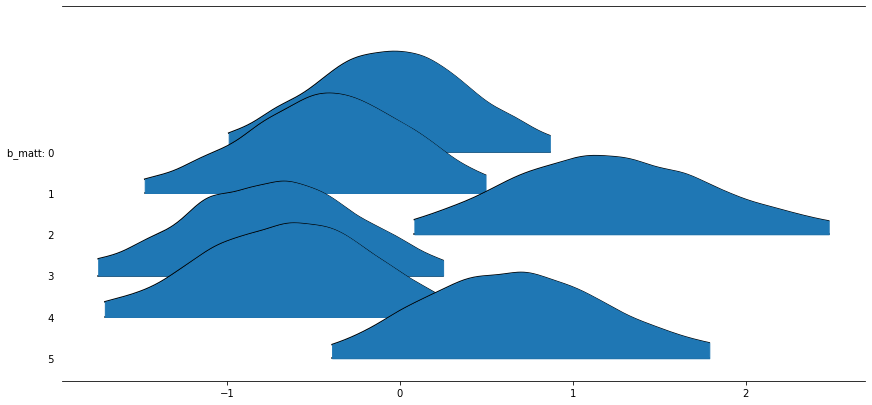

In [17]:
az.plot_forest(trace6, var_names='b_matt',
               combined=True, kind="ridgeplot",
              ridgeplot_truncate=True, 
               )

<AxesSubplot:>

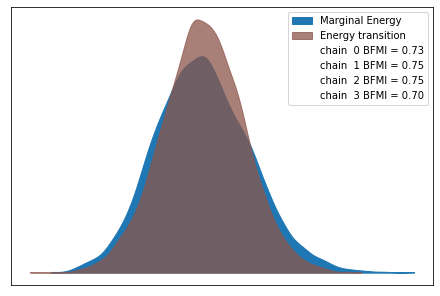

In [20]:
az.plot_energy(trace6)

<AxesSubplot:title={'center':'y_hat'}>

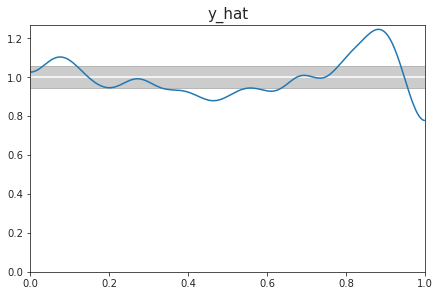

In [88]:
az.plot_bpv(trace6)

In [50]:
trStacked = trace6.posterior.stack(draws=('chain','draw'))


#### Remember the order to use for comparison
'CSminus1':0, 'CSplus1':1, 'CSplusUS1':2, 'CSplus2':3, 'CSminus2':4, 'CSminusUS2':5

In [51]:
trStacked.b_cond.shape

(6, 8000)

In [58]:
csminus1 = trStacked.b_cond[0,:].values
csplus1 = trStacked.b_cond[1,:].values
csPlusUS1 = trStacked.b_cond[2,:].values
csminus2 = trStacked.b_cond[4,:].values
csplus2 = trStacked.b_cond[3,:].values
csPlusUS2 = trStacked.b_cond[5,:].values
csUSboth = np.mean(np.stack([csPlusUS1, csPlusUS2]), axis=0) # averaging across USs
csall = np.mean(np.stack([csminus1,csminus2, csplus1, csplus2]), axis=0) # averaging across CSs
usVcs = csUSboth - csall

<AxesSubplot:ylabel='Count'>

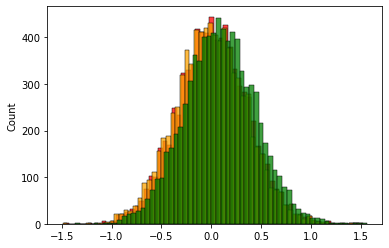

In [62]:
sns.histplot(csminus1, color='red')
sns.histplot(csplus1, color='orange')
sns.histplot(csPlusUS1, color='green')

Text(0.5, 1.0, 'CSPlusUS-CS')

<Figure size 1296x216 with 0 Axes>

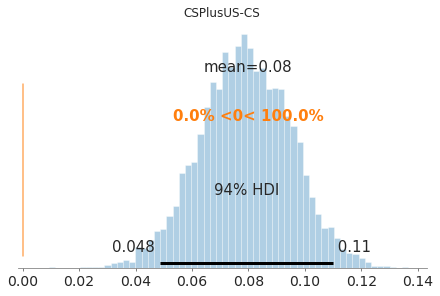

In [67]:
sns.set_style('ticks')
fig = plt.figure(figsize=(18,3))
az.plot_posterior(usVcs, point_estimate='mean', kind='hist', ref_val=0).set_title("CSPlusUS-CS")


In [76]:
print(f'Standardized coeficient {np.mean(usVcs) / np.std(usVcs)}')
az.summary(usVcs)

#

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


Standardized coeficient 4.899582787522149


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
x  0.08  0.016   0.048     0.11        0.0      0.0    5931.0    5040.0    NaN

In [70]:
0.08/0.016

5.0

Text(0.5, 1.0, 'CSPlusUS1-CSplus1')

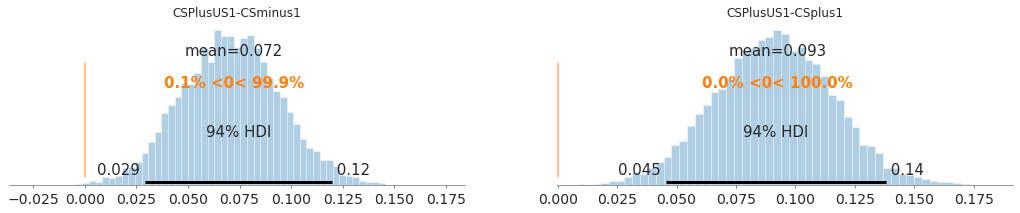

In [77]:
delta = csPlusUS1-csminus1
delta.shape
sns.set_style('ticks')
fig, axes = plt.subplots(1,2, figsize=(18,3), )
az.plot_posterior(delta, point_estimate='mean', kind='hist', ax=axes[0], ref_val=0)
axes[0].set_title("CSPlusUS1-CSminus1")

az.plot_posterior(csPlusUS1-csplus1, point_estimate='mean', kind='hist', ax=axes[1], ref_val=0)
axes[1].set_title("CSPlusUS1-CSplus1")


Text(0.5, 1.0, 'CSPlusUS2-CSplus2')

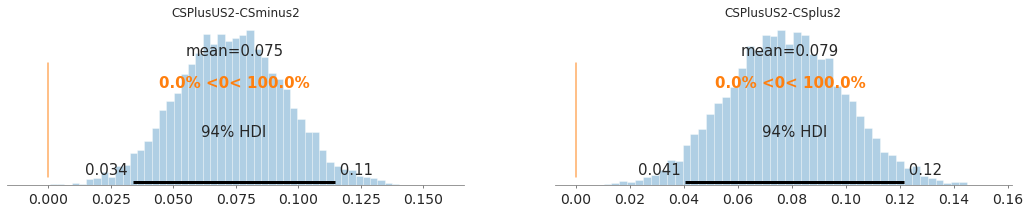

In [78]:
fig, axes = plt.subplots(1,2, figsize=(18,3), )
az.plot_posterior(csPlusUS2-csminus2, point_estimate='mean', kind='hist', ax=axes[0], ref_val=0)
axes[0].set_title("CSPlusUS2-CSminus2")

az.plot_posterior(csPlusUS2-csplus2, point_estimate='mean', kind='hist', ax=axes[1], ref_val=0)
axes[1].set_title("CSPlusUS2-CSplus2")

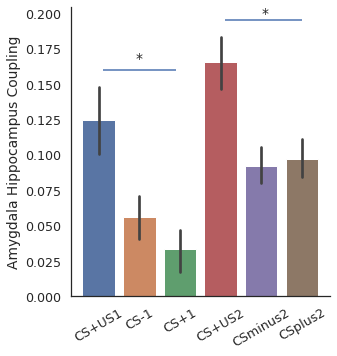

In [98]:
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='coupling',x='condition', data=df, kind='bar', ci=68)
g.set_xlabels("")
g.set_xticklabels(
    labels=["CS+US1", "CS-1", "CS+1", "CS+US2", "CSminus2", "CSplus2"], rotation=30)
plt.text(0.9, 0.165, "*")
plt.hlines(0.16, 0.1,1.9)
plt.text(4, 0.197, "*")
plt.hlines(0.195, 3.1,5)
g.set_ylabels("Amygdala Hippocampus Coupling")
g.savefig('coupling_different_Conditions.png', dpi=300, bbox_inches='tight')

In [72]:
trStacked2 = trace6.posterior.stack(draws=('chain','draw'))

In [73]:
csminus1 = trStacked2.b_cond[0,:].values
csplus1 = trStacked2.b_cond[1,:].values
csPlusUS1 = trStacked2.b_cond[2,:].values


<AxesSubplot:ylabel='Count'>

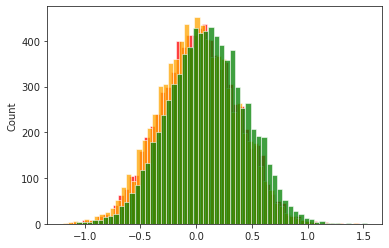

In [74]:
sns.histplot(csminus1, color='red')
sns.histplot(csplus1, color='orange')
sns.histplot(csPlusUS1, color='green')

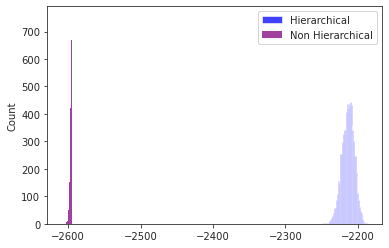

In [80]:
# calculate logP
logP = trace6.sample_stats.lp.stack(draws=('chain','draw'))
logP1 = trace1.sample_stats.lp.stack(draws=('chain','draw'))
sns.histplot(logP, label='Hierarchical', color='blue')
sns.histplot(logP1, label='Non Hierarchical', color='purple')
plt.legend()

### Posterior predictive checks

<AxesSubplot:xlabel='y'>

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


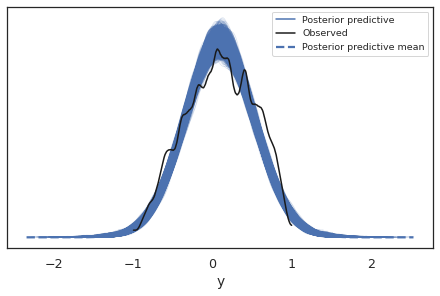

In [153]:
# plot
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model6), var_names='y')

## Next: Assessing SCR using coupling
- Now we will test SCR as predicted variable and coupling as predictor (independent)

In [89]:
glm2 = smf.mixedlm('scr~ coupling + C(condition) + trialNo+ amg', data=df, 
    groups = 'subject', 
                 missing='drop')
model2_f = glm2.fit()
print(model2_f.summary())

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     scr       
No. Observations:       4485        Method:                 REML      
No. Groups:             65          Scale:                  0.3783    
Min. group size:        69          Log-Likelihood:         -4330.8159
Max. group size:        69          Converged:              Yes       
Mean group size:        69.0                                          
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.447    0.067   6.686 0.000  0.316  0.578
C(condition)[T.CSminus2]    0.309    0.044   7.083 0.000  0.224  0.395
C(condition)[T.CSminusUS2]  0.519    0.045  11.459 0.000  0.431  0.608
C(condition)[T.CSplus1]     0.230    0.031   7.370 0.000  0.169  0.291
C(condition)[T.CSplus2]

## Bayes
- We are going to use the same model we chose (model6)

In [90]:
# use reparametarization of the same model
# add hyperpriors
with pm.Model() as model1_scr:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.scr)
   
    
    trace1_scr = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 406 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [96]:
with model1_scr:
    trace1_scr.extend(az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace1_scr)))

In [106]:
az.summary(trace1_scr, var_names=['mu_a','b_coup', 'b_cond'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_a       0.367  0.360  -0.326    1.019      0.005    0.004    4668.0   
b_coup     0.056  0.023   0.010    0.097      0.000    0.000   10129.0   
b_cond[0]  0.070  0.361  -0.596    0.759      0.005    0.004    4480.0   
b_cond[1]  0.298  0.361  -0.387    0.975      0.005    0.004    4465.0   
b_cond[2]  0.722  0.361   0.050    1.400      0.005    0.004    4516.0   
b_cond[3]  0.282  0.362  -0.398    0.967      0.005    0.004    4446.0   
b_cond[4]  0.376  0.362  -0.315    1.045      0.005    0.004    4449.0   
b_cond[5]  0.583  0.363  -0.094    1.280      0.005    0.004    4475.0   

           ess_tail  r_hat  
mu_a         4713.0    1.0  
b_coup       5938.0    1.0  
b_cond[0]    4372.0    1.0  
b_cond[1]    4623.0    1.0  
b_cond[2]    5001.0    1.0  
b_cond[3]    4686.0    1.0  
b_cond[4]    4688.0    1.0  
b_cond[5]    4914.0    1.0

In [107]:
0.056/0.023

2.4347826086956523

In [98]:
trace1_scr

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

In [97]:
y_true = trace1_scr.observed_data["y_hat"].values
y_pred = trace1_scr.posterior_predictive.stack(sample=("chain", "draw"))["y_hat"].values.T
az.r2_score(y_true, y_pred)


r2        0.433154
r2_std    0.003843
dtype: float64

<AxesSubplot:title={'center':'y_hat'}>

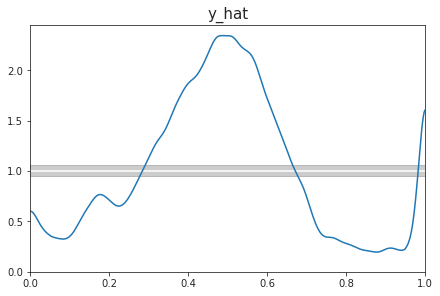

In [104]:
az.plot_bpv(trace1_scr)

<AxesSubplot:title={'center':'b_coup'}>

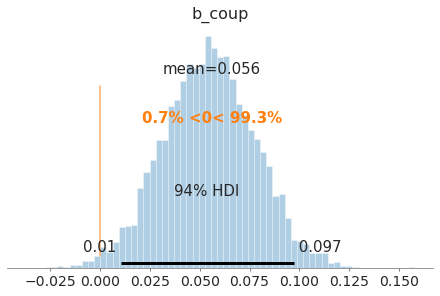

In [105]:
sns.set_style("ticks")
az.plot_posterior(trace1_scr, var_names=['b_coup'], kind='hist', point_estimate='mean',
                 ref_val=0)


<AxesSubplot:xlabel='y_hat'>

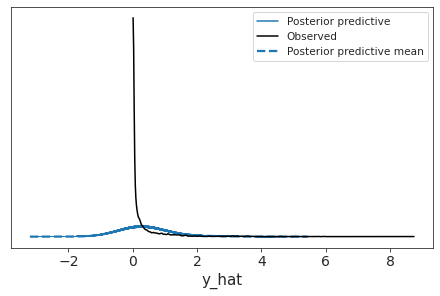

In [108]:
az.plot_ppc(trace1_scr)#az.from_pymc3(posterior_predictive=ppc, model=model1_scr), var_names='y_hat')

## Prediction error and coupling

In [26]:
with pm.Model() as model1_pe:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace1_pe = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 103 seconds.


In [27]:
with pm.Model() as model2_pe:
    
    # adding intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',intercept + a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace2_pe = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 749 seconds.


In [113]:
# adding coupling per subject and hyper parameter
with pm.Model() as model3_pe:
    
    # adding intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    #b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    mu_coup = pm.Normal('mu_coup', mu=0, sigma=.5)
    sigma_coup = pm.HalfCauchy('sigma_coup', .5)
    coup_matt = pm.Normal('coup_matt', mu=0, sd=1, shape=n_sub)
    b_coup = pm.Deterministic('b_coup', mu_coup + sigma_coup*coup_matt)
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',intercept + a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup[subIDX]*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace3_pe = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, coup_matt, sigma_coup, mu_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 887 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b_coup'}>,
        <AxesSubplot:title={'center':'b_coup'}>]], dtype=object)

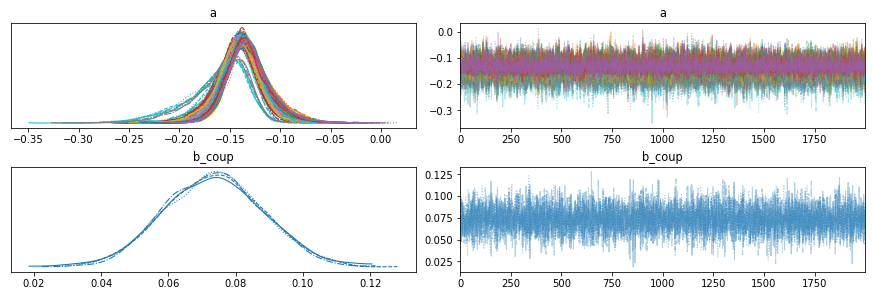

In [28]:
az.plot_trace(trace1_pe, var_names=['a', 'b_coup'])

In [32]:
az.summary(trace2_pe, var_names=['b_coup','b_amg','b_trials', 'mu_a', 'intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_coup     0.074  0.015   0.046    0.101      0.000    0.000   16430.0   
b_amg     -0.006  0.015  -0.033    0.021      0.000    0.000   23931.0   
b_trials   0.001  0.000   0.001    0.002      0.000    0.000   18481.0   
mu_a      -0.029  0.439  -0.866    0.788      0.004    0.005   10318.0   
intercept -0.110  0.439  -0.926    0.726      0.004    0.005   10352.0   

           ess_tail  r_hat  
b_coup       5959.0    1.0  
b_amg        5270.0    1.0  
b_trials     5222.0    1.0  
mu_a         5787.0    1.0  
intercept    5876.0    1.0

In [114]:
az.summary(trace3_pe, var_names=['mu_coup','b_coup','b_amg','b_trials', 'mu_a', 'intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_coup     0.074  0.020   0.037    0.111      0.000    0.000    8815.0   
b_coup[0]  -0.041  0.082  -0.202    0.104      0.001    0.001   12876.0   
b_coup[1]   0.045  0.071  -0.095    0.173      0.001    0.001   18330.0   
b_coup[2]   0.059  0.068  -0.071    0.185      0.001    0.001   18130.0   
b_coup[3]   0.094  0.081  -0.062    0.244      0.001    0.001   22672.0   
...           ...    ...     ...      ...        ...      ...       ...   
b_coup[64]  0.112  0.075  -0.036    0.249      0.001    0.001   17255.0   
b_amg      -0.007  0.014  -0.034    0.020      0.000    0.000   21079.0   
b_trials    0.001  0.000   0.001    0.002      0.000    0.000   22792.0   
mu_a       -0.025  0.442  -0.883    0.782      0.004    0.005   10336.0   
intercept  -0.111  0.442  -0.945    0.721      0.004    0.005   10291.0   

            ess_tail  r_hat  
mu_coup       6527.0    1.0  
b_coup[0]     5406.0    1.0  
b_coup[1]     6091.0    1.0  
b_coup[2]     5929.0    1.0  
b_coup[3]     5791.0    1.0  
...              ...    ...  
b_coup[64]    5719.0    1.0  
b_amg         5296.0    1.0  
b_trials      4543.0    1.0  
mu_a          6090.0    1.0  
intercept     5982.0    1.0  

[70 rows x 9 columns]

In [115]:
0.074/0.020

3.6999999999999997

In [21]:
0.073/0.02

3.65

In [118]:
# test r2 score
with model3_pe:
    trace3_pe.extend(az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace3_pe)))

In [119]:
y_true = trace3_pe.observed_data["y_hat"].values
y_pred = trace3_pe.posterior_predictive.stack(sample=("chain", "draw"))["y_hat"].values.T
az.r2_score(y_true, y_pred)

r2        0.014740
r2_std    0.000254
dtype: float64

In [86]:
0.015/0.00049

30.612244897959183

In [36]:
az.compare({'model1': trace2_pe, 'model2': trace3_pe, 'modeSimple':trace1_pe})

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank          loo      p_loo      d_loo        weight         se  \
model2         0 -2426.819316  38.500178   0.000000  9.868145e-01  50.727138   
modeSimple     1 -2437.318592  12.960532  10.499276  1.318550e-02  50.561381   
model1         2 -2437.450970  13.131509  10.631654  1.110223e-16  50.580939   

                 dse  warning loo_scale  
model2      0.000000    False       log  
modeSimple  4.614297    False       log  
model1      4.614658    False       log

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


<AxesSubplot:xlabel='Log'>

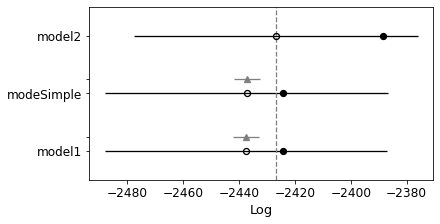

In [39]:
az.plot_compare(az.compare({'model1': trace2_pe, 'model2': trace3_pe, 'modeSimple':trace1_pe}))

In [33]:
az.summary(trace1_pe, var_names=['b_coup','b_amg','b_trials', 'mu_a'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_coup    0.074  0.015   0.046    0.101        0.0      0.0    8471.0   
b_amg    -0.006  0.014  -0.032    0.022        0.0      0.0    9839.0   
b_trials  0.001  0.000   0.001    0.002        0.0      0.0    5488.0   
mu_a     -0.139  0.012  -0.161   -0.115        0.0      0.0    5051.0   

          ess_tail  r_hat  
b_coup      5643.0    1.0  
b_amg       5817.0    1.0  
b_trials    5472.0    1.0  
mu_a        5736.0    1.0

Text(0.5, 1.0, 'Trial No')

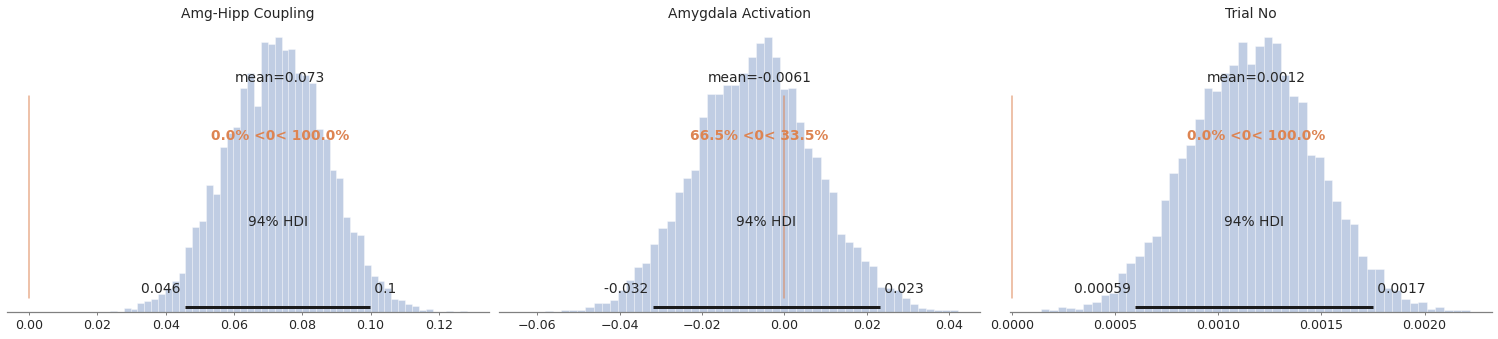

In [59]:
sns.set_style("ticks")
p = az.plot_posterior(trace1_pe, var_names=['b_coup','b_amg','b_trials'],
                 kind='hist', ref_val=0, point_estimate='mean')
p[0].set_title("Amg-Hipp Coupling")
p[1].set_title("Amygdala Activation")
p[2].set_title("Trial No")

In [178]:
with model1_pe:
    ppc = pm.sample_posterior_predictive(trace1_pe)

<AxesSubplot:xlabel='y_hat'>

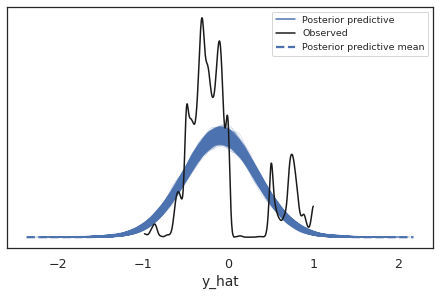

In [179]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model1_pe), var_names='y_hat')

### Using Dirchliet to account for the multiple distributions

In [20]:
with pm.Model() as model:
    w = pm.Dirichlet("w", [1,1])

    mu = pm.Normal(
        "mu",
        [0,0],
        1.0,
        shape=2,
        transform=pm.transforms.ordered,
        testval=[1, 2],
    )
    tau = pm.Gamma("tau", 1.0, 1.0, shape=2)

    x_obs = pm.NormalMixture("x_obs", w, mu, tau=tau, observed=df.pe)

In [21]:
with model:
    trDM = pm.sample()

/tmp/ipykernel_14259/1948356417.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trDM = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

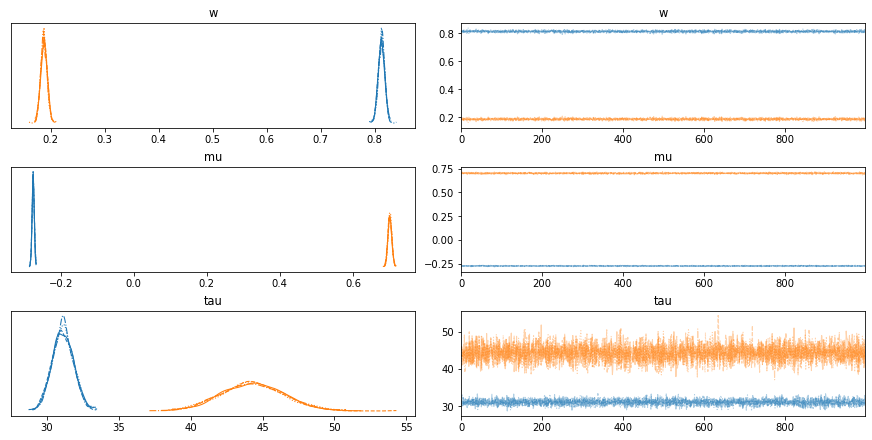

In [22]:
az.plot_trace(trDM)

n         r        CI95%     p-val     BF10     power
pearson  69  0.426161  [0.21, 0.6]  0.000261  102.554  0.960928

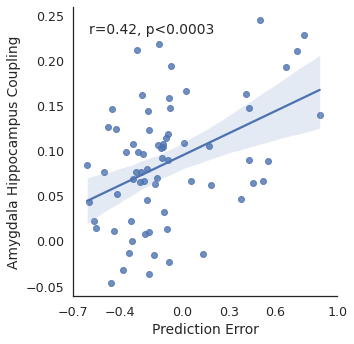

In [9]:
# plot results
forPlot = df.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("white")
a = sns.lmplot(x ='pe', y='coupling', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala Hippocampus Coupling")
plt.text(-0.6,0.23, "r=0.42, p<0.0003")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
a.savefig('pe_coupling.png', dpi=300, bbox_inches='tight')
pg.corr(forPlot['pe'], forPlot['coupling'])

In [ ]:
# ideas
#Ziv - PPI (should be similar to first result) - Did it. similar results.
# Megha - test interaction of PE and alpha on associability
# Megha - histogram of correlation (replacing this one) - did it. Less impressive, but results like the regression model (pe is significantly associated)

In [226]:
# build histogram of correlations:
from scipy import stats
r = []
for sub in df['sub'].unique():
    #print(sub)
    rsub = stats.pearsonr(df['coupling'][df['sub']==sub], df['pe'][df['sub']==sub])
    print(rsub)
    r.append(rsub[0])

(0.3046183637229226, 0.010930337093809505)
(0.09957295151211211, 0.4156275053646665)
(0.33548319811434124, 0.004832585260056897)
(0.26892739215546974, 0.02545643415867279)
(-0.036627215370884855, 0.7650999008751065)
(0.18759804833401994, 0.12269072962135093)
(-0.026999985394925104, 0.8256986349362365)
(0.25549003389908953, 0.034108210584151664)
(0.28413702253287143, 0.017976929058912183)
(-0.04325305503110104, 0.7241721681509811)
(0.23772944679941693, 0.049188873073852724)
(0.1262215003336709, 0.30138847451190764)
(-0.04463752783123829, 0.7157124632665524)
(0.25876916105361997, 0.03179780560874445)
(-0.04365515707246102, 0.7217117100897201)
(0.19395504287664458, 0.11029175591412274)
(0.0304317235966932, 0.803960897068722)
(0.08688187854529095, 0.47779436190043745)
(0.1624495634364958, 0.18232409229954158)
(0.11567747360393288, 0.34388474592067986)
(-0.0384804698939844, 0.7535821229271328)
(-0.16070467012805414, 0.18712962441682487)
(0.08516851059687089, 0.48655155380618315)
(0.05984901

0.08531058150884845

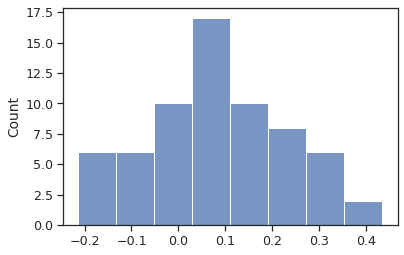

In [229]:
sns.histplot(r)
np.mean(r)
stats.ttest_1samp(r)

## Other Regions
- vmPFC

### General coupling

In [77]:
with pm.Model() as model1_vmpfc:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
   
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df['amg_vmpfc'])
    
    trace1_vmpfc = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 662 seconds.


array([[<AxesSubplot:title={'center':'b_cond'}>,
        <AxesSubplot:title={'center':'b_cond'}>],
       [<AxesSubplot:title={'center':'b_matt'}>,
        <AxesSubplot:title={'center':'b_matt'}>]], dtype=object)

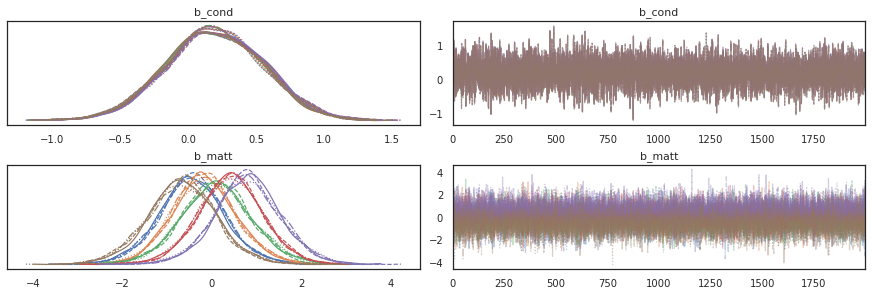

In [171]:
az.plot_trace(trace1_vmpfc, var_names=['b_cond', 'b_matt'])

In [78]:
trStackedvmPFC = trace1_vmpfc.posterior.stack(draws=('chain','draw'))


#### Remember the order to use for comparison
'CSminus1':0, 'CSplus1':1, 'CSplusUS1':2, 'CSplus2':3, 'CSminus2':4, 'CSminusUS2':5

In [79]:
trStackedvmPFC.b_cond.shape


(6, 8000)

In [80]:
csminus1 = trStackedvmPFC.b_cond[0,:].values
csplus1 = trStackedvmPFC.b_cond[1,:].values
csPlusUS1 = trStackedvmPFC.b_cond[2,:].values
csminus2 = trStackedvmPFC.b_cond[4,:].values
csplus2 = trStackedvmPFC.b_cond[3,:].values
csPlusUS2 = trStackedvmPFC.b_cond[5,:].values
csUSboth = np.mean(np.stack([csPlusUS1, csPlusUS2]), axis=0) # averaging across USs
csall = np.mean(np.stack([csminus1,csminus2, csplus1, csplus2]), axis=0) # averaging across CSs
usVcs = csUSboth - csall

<AxesSubplot:ylabel='Count'>

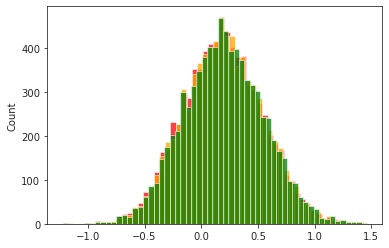

In [81]:
sns.histplot(csminus1, color='red')
sns.histplot(csplus1, color='orange')
sns.histplot(csPlusUS1, color='green')

Text(0.5, 1.0, 'CSPlusUS-CS in vmPFC')

<Figure size 1296x216 with 0 Axes>

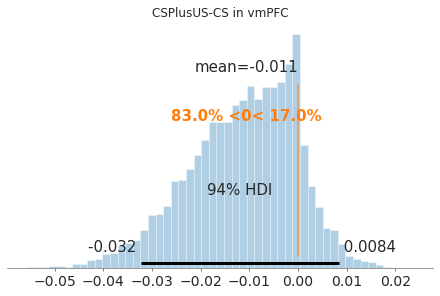

In [82]:
sns.set_style('ticks')
fig = plt.figure(figsize=(18,3))
az.plot_posterior(usVcs, point_estimate='mean', kind='hist', ref_val=0).set_title("CSPlusUS-CS in vmPFC")


In [83]:
print(f'Standardized coeficient {np.mean(usVcs) / np.std(usVcs)}')
az.summary(usVcs)

#

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


Standardized coeficient -0.9414997843973356


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -0.011  0.011  -0.032    0.008        0.0      0.0    5128.0    6366.0   

   r_hat  
x    NaN

Text(0.5, 1.0, 'CSPlusUS1-CSplus1')

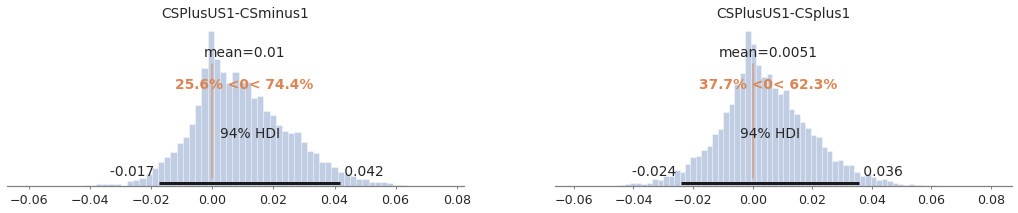

In [176]:
delta = csPlusUS1-csminus1
delta.shape

fig, axes = plt.subplots(1,2, figsize=(18,3), )
az.plot_posterior(delta, point_estimate='mean', kind='hist', ax=axes[0], ref_val=0)
axes[0].set_title("CSPlusUS1-CSminus1")

az.plot_posterior(csPlusUS1-csplus1, point_estimate='mean', kind='hist', ax=axes[1], ref_val=0)
axes[1].set_title("CSPlusUS1-CSplus1")


Text(0.5, 1.0, 'CSPlusUS2-CSplus2')

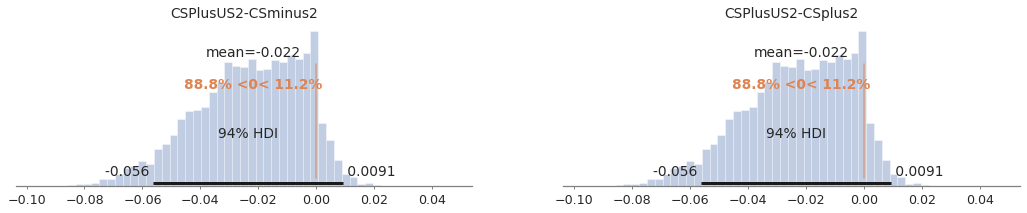

In [177]:
fig, axes = plt.subplots(1,2, figsize=(18,3), )
az.plot_posterior(csPlusUS2-csplus2, point_estimate='mean', kind='hist', ax=axes[0], ref_val=0)
axes[0].set_title("CSPlusUS2-CSminus2")

az.plot_posterior(csPlusUS2-csplus2, point_estimate='mean', kind='hist', ax=axes[1], ref_val=0)
axes[1].set_title("CSPlusUS2-CSplus2")

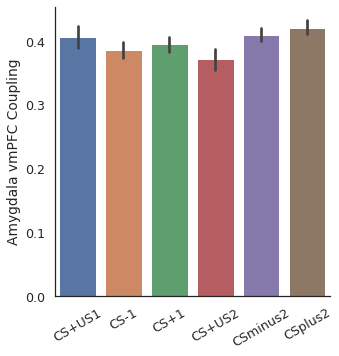

In [167]:
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='coupling',x='condition', data=dfvmpfc, kind='bar', ci=68)
g.set_xlabels("")
g.set_xticklabels(
    labels=["CS+US1", "CS-1", "CS+1", "CS+US2", "CSminus2", "CSplus2"], rotation=30)
g.set_ylabels("Amygdala vmPFC Coupling")
#g.savefig('coupling_different_Conditions.png', dpi=300, bbox_inches='tight')

### Behvarior (SCR)

In [107]:
df.head()

sub  Condition  Event.Nr  CDA.AmpSum  expected_value        pe     scr  \
0  sub-189  CSplusUS1         1      0.2852        0.775073  0.500000  0.2852   
1  sub-189   CSminus1         2      0.1033        0.772940 -0.500000  0.1033   
2  sub-189    CSplus1         3      0.0783        0.774003 -0.500680  0.0783   
3  sub-189  CSplusUS1         4      0.1772        0.775070  0.500002  0.1772   
4  sub-189   CSminus1         5      0.0000        0.771878 -0.499320  0.0000   

   index  subject  trialNo  condition  coupling       amg  amg_vmpfc  \
0   1794  sub-189        1  CSplusUS1  0.309524  0.981121   0.476190   
1   1795  sub-189        2   CSminus1 -0.571429 -0.027048   0.690476   
2   1796  sub-189        3    CSplus1 -0.476190 -0.045910   0.285714   
3   1797  sub-189        4  CSplusUS1  0.166667 -0.674150   0.547619   
4   1798  sub-189        5   CSminus1  0.214286 -0.065602   0.761905   

   amg_HippAnt  cond  
0     0.285714     2  
1    -0.047619     0  
2     0.428571     1  
3     0.357143     2  
4    -0.309524     0

In [134]:
n_sub

65

In [110]:
# use reparametarization of the same model
# add hyperpriors
with pm.Model() as scr_vmpfc:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    #mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_vmpfc)
    
    mu = a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_vmpfc
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.scr)
   
    
    trace1_scr_vmpfc = pm.sample(target_accept=.98, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000, random_seed=145)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 489 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [111]:
az.summary(trace1_scr_vmpfc, var_names=['b_coup','b_cond','b_matt'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_coup     0.020  0.027  -0.030    0.070      0.000    0.000    7692.0   
b_cond[0]  0.063  0.359  -0.603    0.732      0.007    0.005    2444.0   
b_cond[1]  0.289  0.360  -0.390    0.949      0.007    0.005    2439.0   
b_cond[2]  0.719  0.361   0.010    1.359      0.007    0.005    2428.0   
b_cond[3]  0.270  0.361  -0.401    0.952      0.007    0.005    2446.0   
b_cond[4]  0.365  0.361  -0.298    1.049      0.007    0.005    2430.0   
b_cond[5]  0.578  0.361  -0.092    1.261      0.007    0.005    2439.0   
b_matt[0] -1.173  0.592  -2.255   -0.060      0.016    0.011    1448.0   
b_matt[1] -0.295  0.441  -1.086    0.560      0.012    0.008    1366.0   
b_matt[2]  1.371  0.572   0.352    2.500      0.013    0.009    1827.0   
b_matt[3] -0.366  0.444  -1.198    0.462      0.012    0.009    1341.0   
b_matt[4] -0.002  0.419  -0.804    0.764      0.012    0.008    1249.0   
b_matt[5]  0.825  0.470  -0.039    1.727      0.012    0.008    1640.0   

           ess_tail  r_hat  
b_coup       6001.0    1.0  
b_cond[0]    4024.0    1.0  
b_cond[1]    4012.0    1.0  
b_cond[2]    4098.0    1.0  
b_cond[3]    4142.0    1.0  
b_cond[4]    4132.0    1.0  
b_cond[5]    3960.0    1.0  
b_matt[0]    2556.0    1.0  
b_matt[1]    2512.0    1.0  
b_matt[2]    3328.0    1.0  
b_matt[3]    2228.0    1.0  
b_matt[4]    2354.0    1.0  
b_matt[5]    2942.0    1.0

In [112]:
0.02/0.027

0.7407407407407408

<AxesSubplot:title={'center':'b_coup'}>

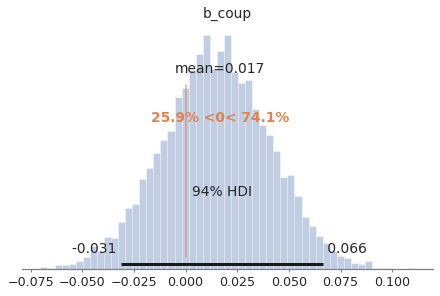

In [165]:
az.plot_posterior(trace1_scr_vmpfc,var_names=['b_coup'], kind='hist', ref_val=0, point_estimate='mean')

In [228]:
with pm.Model() as model1_pe_vmpfc:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=5)
    sigma_a = pm.HalfCauchy('sigma_a', 1)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=5)
     
    eps = pm.HalfCauchy('eps', 5)
    
    # make mu a determenistic distribution so we can test later vs. actual data  
    mu = pm.Deterministic('mu',a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_vmpfc)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
 
    trace1_pe_vmpfc = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


AssertionError: ('The following error happened while compiling the node', Elemwise{Composite{sqr((i0 - (i1 + (i2 * i3) + (i4 * i5) + (i6 * i7))))}}[(0, 1)](TensorConstant{[ 0.5     ...18996728]}, AdvancedSubtensor1.0, InplaceDimShuffle{x}.0, TensorConstant{[ 0.  1.  ... 67. 68.]}, InplaceDimShuffle{x}.0, TensorConstant{[ 0.981121...17744505]}, InplaceDimShuffle{x}.0, TensorConstant{[0.9047619...8       ]}), '\n')

In [120]:
# adding coupling per subject and hyper parameter
with pm.Model() as model3_pe_vmpfc:
    
    # adding intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    #b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    mu_coup = pm.Normal('mu_coup', mu=0, sigma=.5)
    sigma_coup = pm.HalfCauchy('sigma_coup', .5)
    coup_matt = pm.Normal('coup_matt', mu=0, sd=1, shape=n_sub)
    b_coup = pm.Deterministic('b_coup', mu_coup + sigma_coup*coup_matt)
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',intercept + a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup[subIDX]*df.amg_vmpfc)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace3_pe_vmpfc = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, coup_matt, sigma_coup, mu_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 854 seconds.


In [121]:
az.summary(trace3_pe_vmpfc, var_names=['mu_coup','b_coup','b_amg','mu_a'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_coup    -0.030  0.018  -0.065    0.002      0.000    0.000   17261.0   
b_coup[0]  -0.020  0.037  -0.089    0.053      0.000    0.000   12317.0   
b_coup[1]  -0.038  0.036  -0.113    0.030      0.000    0.000   13918.0   
b_coup[2]  -0.023  0.035  -0.086    0.048      0.000    0.000   13084.0   
b_coup[3]  -0.024  0.034  -0.087    0.047      0.000    0.000   15136.0   
...           ...    ...     ...      ...        ...      ...       ...   
b_coup[62] -0.019  0.037  -0.088    0.054      0.000    0.000   12748.0   
b_coup[63] -0.026  0.036  -0.096    0.045      0.000    0.000   14554.0   
b_coup[64] -0.029  0.036  -0.098    0.045      0.000    0.000   17111.0   
b_amg      -0.003  0.014  -0.030    0.024      0.000    0.000   18898.0   
mu_a       -0.033  0.451  -0.885    0.792      0.004    0.005   11843.0   

            ess_tail  r_hat  
mu_coup       6116.0    1.0  
b_coup[0]     6039.0    1.0  
b_coup[1]     5869.0    1.0  
b_coup[2]     5874.0    1.0  
b_coup[3]     6618.0    1.0  
...              ...    ...  
b_coup[62]    6335.0    1.0  
b_coup[63]    5437.0    1.0  
b_coup[64]    5957.0    1.0  
b_amg         6469.0    1.0  
mu_a          5846.0    1.0  

[68 rows x 9 columns]

In [123]:
0.03/0.018

1.6666666666666667

array([<AxesSubplot:title={'center':'mu_coup'}>,
       <AxesSubplot:title={'center':'b_amg'}>], dtype=object)

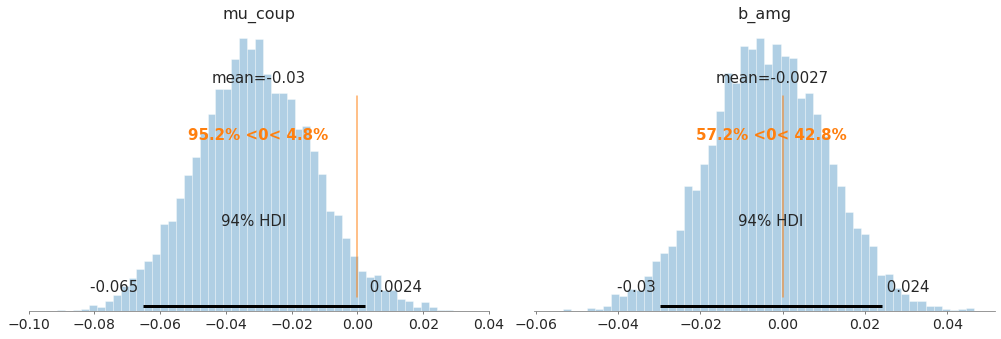

In [122]:
sns.set_style("ticks")
az.plot_posterior(trace3_pe_vmpfc, var_names=['mu_coup','b_amg'], kind='hist',
                 ref_val=0)

## Anterior Hippocampus

In [45]:
with pm.Model() as model1_ah:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
   
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df['amg_HippAnt'])
    
    trace1_ah = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 604 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [46]:
trStackedAH= trace1_ah.posterior.stack(draws=('chain','draw'))


In [47]:
csminus1 = trStackedAH.b_cond[0,:].values
csplus1 = trStackedAH.b_cond[1,:].values
csPlusUS1 = trStackedAH.b_cond[2,:].values
csminus2 = trStackedAH.b_cond[4,:].values
csplus2 = trStackedAH.b_cond[3,:].values
csPlusUS2 = trStackedAH.b_cond[5,:].values

<AxesSubplot:ylabel='Count'>

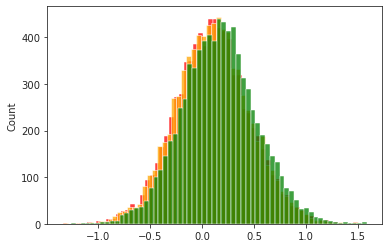

In [48]:
sns.histplot(csminus1, color='red')
sns.histplot(csplus1, color='orange')
sns.histplot(csPlusUS1, color='green')

Text(0.5, 1.0, 'CSPlusUS1-CSplus1')

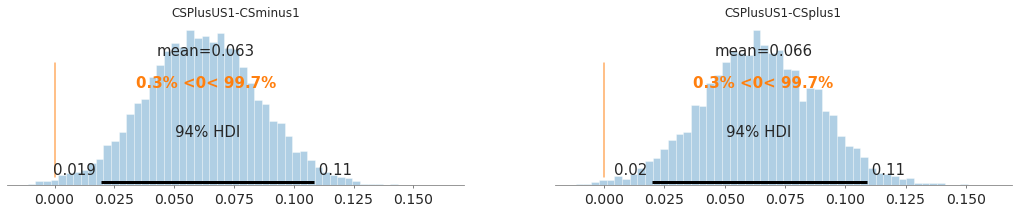

In [49]:
delta = csPlusUS1-csminus1
delta.shape

fig, axes = plt.subplots(1,2, figsize=(18,3), )
az.plot_posterior(delta, point_estimate='mean', kind='hist', ax=axes[0], ref_val=0)
axes[0].set_title("CSPlusUS1-CSminus1")

az.plot_posterior(csPlusUS1-csplus1, point_estimate='mean', kind='hist', ax=axes[1], ref_val=0)
axes[1].set_title("CSPlusUS1-CSplus1")


Text(0.5, 1.0, 'CSPlusUS2-CSplus2')

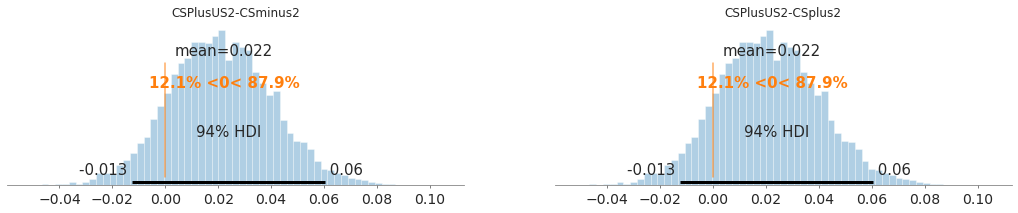

In [50]:
fig, axes = plt.subplots(1,2, figsize=(18,3), )
az.plot_posterior(csPlusUS2-csplus2, point_estimate='mean', kind='hist', ax=axes[0], ref_val=0)
axes[0].set_title("CSPlusUS2-CSminus2")

az.plot_posterior(csPlusUS2-csplus2, point_estimate='mean', kind='hist', ax=axes[1], ref_val=0)
axes[1].set_title("CSPlusUS2-CSplus2")

Anterior and SCR

In [51]:
with pm.Model() as scr_ah:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    #mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_vmpfc)
    
    mu = a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_HippAnt
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.scr)
   
    
    trace1_scr_ah = pm.sample(target_accept=.98, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 528 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [52]:
az.summary(trace1_scr_ah, var_names=['b_coup','b_cond','b_matt'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_coup     0.031  0.025  -0.017    0.077      0.000    0.000    6204.0   
b_cond[0]  0.072  0.363  -0.626    0.751      0.007    0.005    2622.0   
b_cond[1]  0.299  0.363  -0.396    0.981      0.007    0.005    2619.0   
b_cond[2]  0.726  0.364   0.043    1.416      0.007    0.005    2644.0   
b_cond[3]  0.280  0.365  -0.447    0.943      0.007    0.005    2621.0   
b_cond[4]  0.374  0.365  -0.331    1.058      0.007    0.005    2602.0   
b_cond[5]  0.585  0.365  -0.130    1.259      0.007    0.005    2611.0   
b_matt[0] -1.164  0.579  -2.291   -0.113      0.015    0.010    1543.0   
b_matt[1] -0.288  0.429  -1.088    0.503      0.011    0.008    1541.0   
b_matt[2]  1.355  0.573   0.277    2.435      0.014    0.010    1676.0   
b_matt[3] -0.362  0.438  -1.210    0.429      0.011    0.008    1496.0   
b_matt[4]  0.001  0.414  -0.753    0.781      0.011    0.008    1505.0   
b_matt[5]  0.814  0.469  -0.076    1.682      0.012    0.008    1618.0   

           ess_tail  r_hat  
b_coup       6122.0    1.0  
b_cond[0]    4416.0    1.0  
b_cond[1]    4289.0    1.0  
b_cond[2]    4284.0    1.0  
b_cond[3]    4237.0    1.0  
b_cond[4]    4222.0    1.0  
b_cond[5]    4065.0    1.0  
b_matt[0]    2397.0    1.0  
b_matt[1]    2631.0    1.0  
b_matt[2]    3131.0    1.0  
b_matt[3]    2432.0    1.0  
b_matt[4]    2637.0    1.0  
b_matt[5]    3093.0    1.0

In [53]:
# prediction error

In [54]:
# adding coupling per subject and hyper parameter
with pm.Model() as model3_pe_ah:
    
    # adding intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    #b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    mu_coup = pm.Normal('mu_coup', mu=0, sigma=.5)
    sigma_coup = pm.HalfCauchy('sigma_coup', .5)
    coup_matt = pm.Normal('coup_matt', mu=0, sd=1, shape=n_sub)
    b_coup = pm.Deterministic('b_coup', mu_coup + sigma_coup*coup_matt)
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',intercept + a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup[subIDX]*df.amg_HippAnt)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace3_pe_ah = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, coup_matt, sigma_coup, mu_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 889 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [55]:
az.summary(trace3_pe_ah, var_names=['mu_coup','b_coup','b_amg','mu_a'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_coup     0.050  0.018   0.017    0.084      0.000    0.000   13211.0   
b_coup[0]   0.033  0.060  -0.085    0.146      0.000    0.001   17092.0   
b_coup[1]   0.048  0.061  -0.061    0.174      0.000    0.001   16923.0   
b_coup[2]   0.087  0.057  -0.014    0.203      0.001    0.000    9843.0   
b_coup[3]   0.062  0.059  -0.046    0.182      0.000    0.001   18326.0   
...           ...    ...     ...      ...        ...      ...       ...   
b_coup[62]  0.028  0.062  -0.099    0.138      0.000    0.001   17153.0   
b_coup[63]  0.113  0.066  -0.002    0.239      0.001    0.001    6270.0   
b_coup[64] -0.013  0.070  -0.150    0.107      0.001    0.001    6058.0   
b_amg      -0.004  0.014  -0.031    0.023      0.000    0.000   20360.0   
mu_a       -0.033  0.447  -0.855    0.824      0.004    0.006   11211.0   

            ess_tail  r_hat  
mu_coup       6326.0    1.0  
b_coup[0]     6169.0    1.0  
b_coup[1]     6092.0    1.0  
b_coup[2]     6173.0    1.0  
b_coup[3]     6273.0    1.0  
...              ...    ...  
b_coup[62]    5918.0    1.0  
b_coup[63]    5645.0    1.0  
b_coup[64]    5777.0    1.0  
b_amg         4335.0    1.0  
mu_a          5348.0    1.0  

[68 rows x 9 columns]

array([<AxesSubplot:title={'center':'mu_coup'}>,
       <AxesSubplot:title={'center':'b_amg'}>], dtype=object)

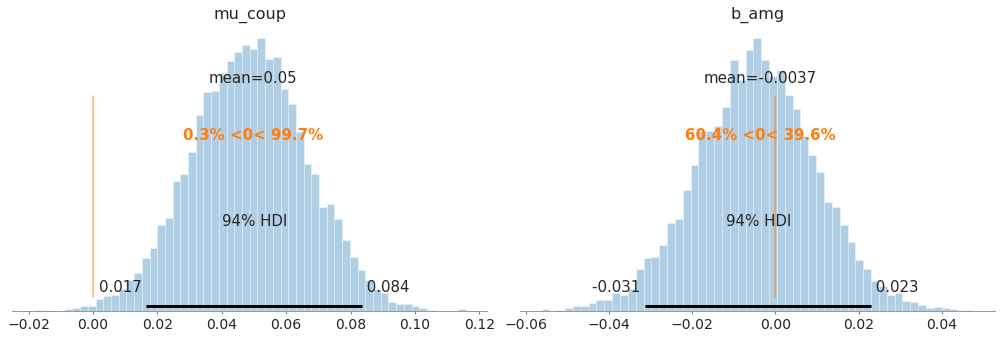

In [56]:
sns.set_style("ticks")
az.plot_posterior(trace3_pe_ah, var_names=['mu_coup','b_amg'], kind='hist',
                 ref_val=0)

n         r         CI95%     p-val    BF10     power
pearson  69  0.372694  [0.15, 0.56]  0.001612  19.574  0.892749

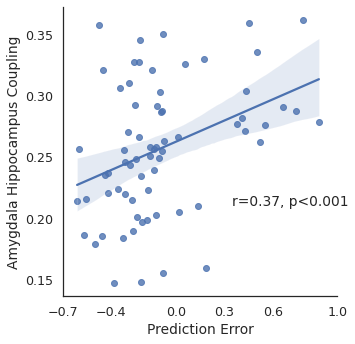

In [7]:
# plot results
forPlot = df.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("white")
a = sns.lmplot(x ='pe', y='amg_HippAnt', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala Hippocampus Coupling")
plt.text(0.35,0.21, "r=0.37, p<0.001")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
a.savefig('pe_couplingAnteriorHippocampus.png', dpi=300, bbox_inches='tight')
pg.corr(forPlot['pe'], forPlot['amg_HippAnt'])

n         r          CI95%     p-val   BF10     power
pearson  69 -0.220047  [-0.43, 0.02]  0.069248  0.757  0.447808

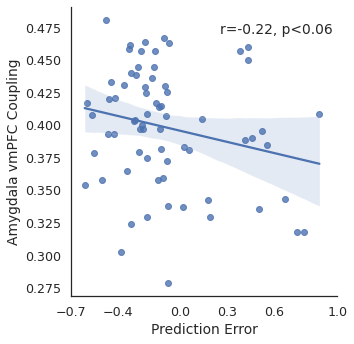

In [15]:
# vmpfc
# plot results
forPlot = df.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("white")
a = sns.lmplot(x ='pe', y='amg_vmpfc', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala vmPFC Coupling")
plt.text(0.25,0.47, "r=-0.22, p<0.06")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
a.savefig('pe_couplingVMPFC.png', dpi=300, bbox_inches='tight')
pg.corr(forPlot['pe'], forPlot['amg_vmpfc'])